In [14]:
# Solving Boltzmann Equations for Dark Matter Relic Abundance

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.special import kn
styles = [r'figure_formatting/styles/aps.mplstyle']
from figure_formatting.plotting_utils import *
%matplotlib inline
import csv


# Constants
G_N = 6.67430e-11  # Gravitational constant in m^3 kg^-1 s^-2
c = 2.99792458e8   # Speed of light in m/s
hbar = 1.054571817e-34  # Reduced Planck constant in J⋅s
k_B = 1.380649e-23  # Boltzmann constant in J/K
M_Pl = np.sqrt(hbar * c / (8 * np.pi * G_N))  # Reduced Planck mass in kg
H_0 = 68.4*(1/3.086e19)*(6.58e-16)*(1e-9) # in GeV
h = 0.684
G_eV_2 = 6.7*1e-39
g_x = 2

# Convert to natural units (GeV)
M_Pl_GeV = M_Pl * c**2 / 1.602176634e-10

# Function to calculate g_*(T)
def g_star(T):
    # Convert input to numpy array if it's not already
    T = np.asarray(T)
    
    # Initialize output array with the same shape as input
    result = np.empty_like(T)
    
    # Apply conditions using numpy's where function
    result = np.where(T > 175, 106.75,
                      np.where(T > 200e-3, 80, 10.75))
    
    return result

T_values, g_values = [],[]
with open('sm_dof_freezeout.csv', 'r') as file:
    csv_reader = csv.reader(file)
    next(csv_reader)  # Skip header row if present
    for row in csv_reader:
        T_values.append(float(row[0]))
        g_values.append(float(row[1]))

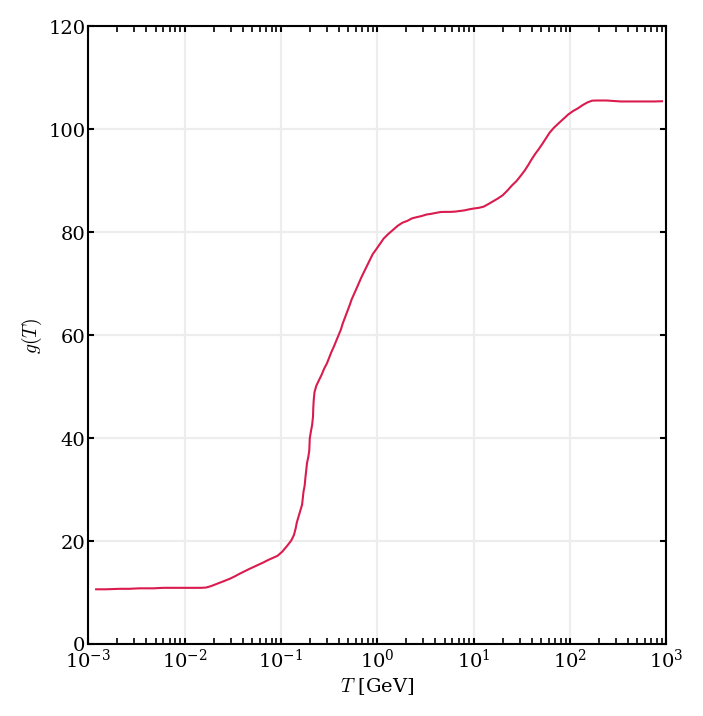

In [15]:
with plt.style.context(styles):
    fig = figure(ratio=1)
    ax = add_subplot(fig, 1, 1, 0, 1, 0, 1, ylabellen=40.3/2)
    set_ylim(ax, 0, 120, log=False, eps=0)
    set_xlim(ax, 1e-3, 1e3, log=True, eps=0)
    ax.set_xlabel(r'$T$ [GeV]')
    ax.set_ylabel(r'$g(T)$')
    ax.grid()
    ax.plot(T_values, g_values)


/var/folders/21/f2gf_6cj1wg4_0ctkgk8jyr40000gn/T/ipykernel_23365/81795618.py:12: RuntimeWarning: overflow encountered in exp
  return (2/np.sqrt(np.pi))*Sbsf(np.sqrt(z_x/u))*np.sqrt(u)/(np.exp(u) - np.exp(-z))


(0.1, 10000)

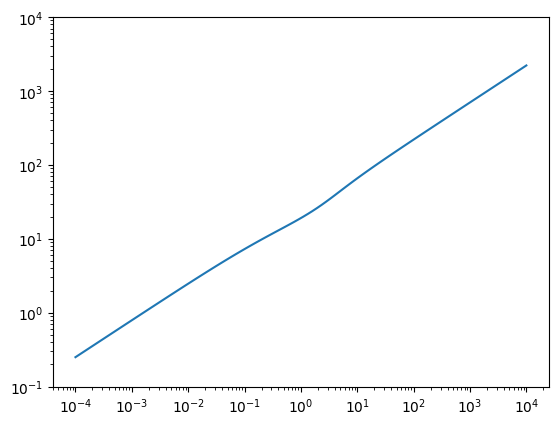

In [31]:
def Sann(eta):
    return 2*np.pi*eta/(1-np.exp(-2*np.pi*eta))

def Sbsf(eta, n=1):
    etan = eta/n
    return ((2**10) * np.pi/3) * (etan**5) * np.exp(-4*etan*(np.pi/2 - np.arctan(etan)))/(n*((1 + etan**2)**2)*(1 - np.exp(-2*np.pi*etan)))

def intSann(u, z_x):
    return (2/np.sqrt(np.pi))*Sann(np.sqrt(z_x/u))*np.sqrt(u)*np.exp(-u)

def intSbsf(u, z_x, z):
    return (2/np.sqrt(np.pi))*Sbsf(np.sqrt(z_x/u))*np.sqrt(u)/(np.exp(u) - np.exp(-z))

def intfion(u, z):
    return (2**7/3)* u * np.exp(-4*u*(np.pi/2 - np.arctan(u)))/(((1 + u**2)**2)*(1 - np.exp(-2*np.pi*u))*(np.exp(z*(1 + 1/u**2)) - 1))

from scipy import integrate

def calculate_integral(integrand, params):
    result, error = integrate.quad(integrand, 0, np.inf, args=params)
    return result, error

# Example usage

z_x = np.logspace(-4, 4, 100)
res = []
for _zx in z_x:
    result, error = calculate_integral(intSbsf, (_zx, _zx))
    res.append(result)

plt.plot(z_x, res)
plt.xscale('log')
plt.yscale('log')
plt.ylim(0.1,10000)

In [77]:
gstar = 108.75
alpha = 0.0247
Delta = (alpha**2)/4
m_DM = 100
mu = m_DM/2
sigma_0 = np.pi*((alpha/m_DM)**2)

c1 = np.sqrt(np.pi/45) * M_Pl_GeV*Delta*np.sqrt(gstar)*sigma_0
c2 = np.sqrt(45/(4*(np.pi**3)*np.sqrt(gstar))) * M_Pl_GeV * (alpha**5) * mu/(Delta**2)
ca = 4*(np.pi**2 - 9)*alpha/(9*np.pi)
z_kd = 100*((alpha/0.02)**3)*np.sqrt(10/m_DM) 


def n_eq(x, m_DM=100, g_x=2):
    return (g_x * (m_DM**3) * kn(2, x)) / (2 * (np.pi**2) * x)
    #return g_x * ((m_DM**2/(2*np.pi*x))**(3/2)) * np.exp(-x)

def s(x, m_DM):
    return (2 * (np.pi**2) / 45) * gstar * ((m_DM/x)**3)  # Entropy density

def Y_eq(x, m_DM=100, g_x=2):
    return n_eq(x, m_DM, g_x)/s(x, m_DM)

def barSann(z_x):
    return calculate_integral(intSann, (z_x))[0]

def barSbsf(z_x, z):
    return calculate_integral(intSbsf, (z_x, z))[0]

def fion(z):
    return calculate_integral(intfion, (z))[0]
0

0

In [78]:
# Boltzmann equation
def boltzmann_eqs_W(z, W, sigma_v, m_DM):
    # Y is n/s, x is m/T
    W_x, W_pm, W_pp = W
    x = z*4/(alpha**2)
    z_x = z if z <= z_kd else (z**2)/z_kd

    Y_eq_u = Y_eq(x, m_DM) # Equilibrium number density
    W_eq = -np.inf if Y_eq_u == 0 else np.log(Y_eq_u)

    dW_xdz = -c1*barSann(z_x)*(np.exp(W_x - 2*W_eq) - np.exp(W_x))/(z**2)  \
                - c1*barSbsf(z_x,z)*np.exp(W_x)/(z**2) \
                + c2*z*fion(z)*(np.exp(-W_x + W_pm) + np.exp(-W_x + W_pp))
    dW_pmdz = c1*barSbsf(z_x, z)*np.exp(2*W_x - W_pm)/(4*(z**2)) \
                - c2*z*(1 + fion(z))
    dW_ppdz = 3*c1*barSbsf(z_x, z)*np.exp(2*W_x - W_pp)/(4*(z**2)) \
                - c2*z*(ca + fion(z))
    
    return [dW_xdz]#, dW_pmdz, dW_ppdz]

# Function to solve Boltzmann equation
def solve_boltzmann_W(z, m_DM, sigma_v, W_0):
    sol = integrate.solve_ivp(boltzmann_eqs_W, [z[0], z[-1]], W_0, args=(sigma_v, m_DM), method='Radau')
    
    y = sol.y
    t = sol.t
    # Calculate Omega_DM
    rho_c = 3 * H_0**2 / (8 * np.pi * G_eV_2)  # Critical density
    s_0 = s(m_DM/(2.35*1e-13), m_DM)  # Current entropy density in eV cm^-3

    Omega_hh_DM = h * h* m_DM * np.exp(y[-1][-1]) * s_0 / rho_c

    return t, y, Omega_hh_DM
    

In [80]:
sol = integrate.solve_ivp(boltzmann_eqs_W, [1e-3, 1e3], [-8,-12,-16], args=(5, 100))

#boltzmann_eqs_W(1, [-8,-12,-15], 5, 100)

#barSbsf(0.001, 0.001)

/var/folders/21/f2gf_6cj1wg4_0ctkgk8jyr40000gn/T/ipykernel_23365/81795618.py:12: RuntimeWarning: overflow encountered in exp
  return (2/np.sqrt(np.pi))*Sbsf(np.sqrt(z_x/u))*np.sqrt(u)/(np.exp(u) - np.exp(-z))
/var/folders/21/f2gf_6cj1wg4_0ctkgk8jyr40000gn/T/ipykernel_23365/81795618.py:15: RuntimeWarning: overflow encountered in exp
  return (2**7/3)* u * np.exp(-4*u*(np.pi/2 - np.arctan(u)))/(((1 + u**2)**2)*(1 - np.exp(-2*np.pi*u))*(np.exp(z*(1 + 1/u**2)) - 1))


KeyboardInterrupt: 

[np.float64(-8.173942467055864), np.float64(-12.988772847615698), np.float64(-14.087385136283807)]
0.0007626124999999999 5956.6334061244415


/var/folders/21/f2gf_6cj1wg4_0ctkgk8jyr40000gn/T/ipykernel_23365/81795618.py:15: RuntimeWarning: overflow encountered in exp
  return (2**7/3)* u * np.exp(-4*u*(np.pi/2 - np.arctan(u)))/(((1 + u**2)**2)*(1 - np.exp(-2*np.pi*u))*(np.exp(z*(1 + 1/u**2)) - 1))


ValueError: x and y must have same first dimension, but have shapes (1,) and (3,)

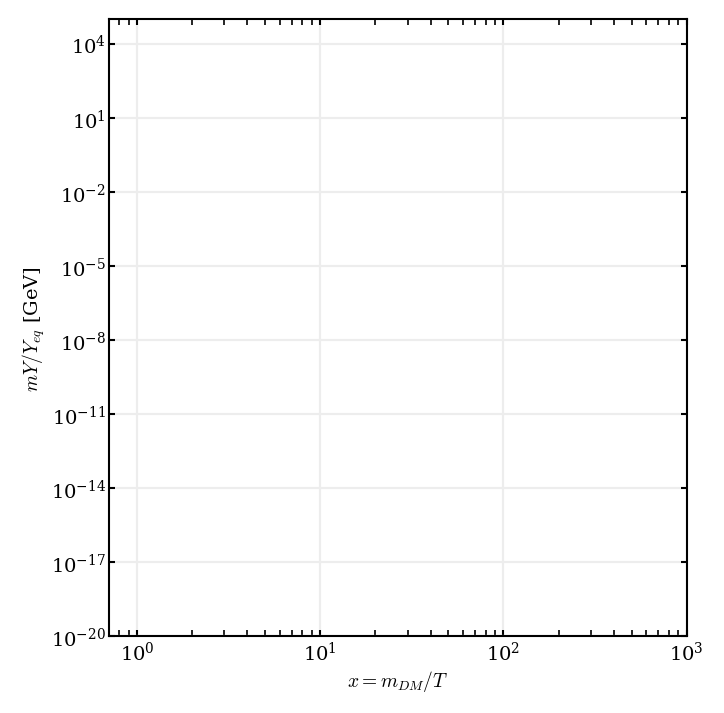

In [47]:
with plt.style.context(styles):
    fig = figure(ratio=1)
    ax = add_subplot(fig, 1, 1, 0, 1, 0, 1, ylabellen=40.3/2)
    set_ylim(ax, 1e-20, 1e5, log=True, eps=0)
    set_xlim(ax, 0.7, 1e3, log=True, eps=0)
    ax.set_xlabel(r'$x = m_{DM} / T$')
    ax.set_ylabel(r'$mY /Y_{eq}$ [GeV]')
    ax.grid()

    xi = 5
    z = np.logspace(np.log10(xi*(alpha**2)/4), np.log10(100*z_kd), 1000)  # From x=1 to x=1000

    for m_DM, ls in zip([1,100,1000],[':', '--', '-.']):
        Y_eq_0 = Y_eq(xi, m_DM)

        #Y_eq_p = n_eq(x, m_DM=m_DM)/s(x, m_DM=m_DM)
        #if m_DM == 100:
        #    ax.plot(x, m_DM*(Y_eq_p/Y_eq_0), c='black', label='Equilibrium')

        for sigma_v, c, label in zip([2e-15, 2e-21, 2e-26], ['b','g','r'], ['strong', 'em', 'weak']):
            if m_DM == 100 or c == 'r':
                W_0 = [np.log(Y_eq(xi, m_DM)), np.log(Y_eq(2*xi - z[0])/g_x), np.log(Y_eq(2*xi - z[0])/g_x/3)]
                print(W_0)
                u_sol, W, Omega_hh_DM = solve_boltzmann_W(z, m_DM, sigma_v, W_0)
                #x_sol = np.exp(u_sol)
                #s_p = s(x_sol, m_DM)
                print(z[0], z[-1])
                ax.plot(x_sol, m_DM*np.exp(np.ravel(W))/Y_eq_0, c=c, linestyle=ls, label=r'$m='+str(m_DM)+r'$ GeV, $\langle\sigma v\rangle_{'+label+'}$')

import matplotlib.ticker as ticker
locmaj = ticker.LogLocator(base=10,numticks=27) 
ax.yaxis.set_minor_locator(locmaj)
ax.xaxis.set_minor_formatter(ticker.NullFormatter())
align_ticklabels(ax, axis='y', ticks=np.logspace(-20, 5, 26), ticklabels=[r'$10^{'+str(int(i))+'}$' for i in range(-20, 6)])
align_ticklabels(ax, axis='x', ticks=np.logspace(0, 3, 4), ticklabels=[r'$10^{'+str(int(i))+'}$' for i in range(0, 4)])
#align_ticklabels(ax, axis='y', ticks=np.logspace(-20, 5, 26), ticklabels=ax.get_yticklabels())
ax.legend(fontsize=5)
fig.savefig('re_steigman2012_fig1.pdf')

In [245]:
t = 5
n_eq_0 = n_eq(np.exp(0), 100) # Equilibrium number density
s_0 = s(np.exp(0), 100)  # Entropy density
y_0 = n_eq_0/s_0
n_eq_u = n_eq(np.exp(t), 100) # Equilibrium number density
s_u = s(np.exp(t), 100)  # Entropy density
y = n_eq_u/s_u

100*y/y_0

100*y/y_0, s_u/s_0, n_eq_u/n_eq_0

(np.float64(7.201552878456312e-60),
 np.float64(2.1041035536930388e-07),
 np.float64(1.515281300366826e-68))

In [172]:
m_DM_list = np.logspace(-1, 4, 20)
sigma_v_list = np.linspace(0, 10e-26, 50)
u = np.logspace(0, 3, 1000)  # From x=1 to x=100
x = np.exp(u)


sigma_v_res = np.zeros(shape=(len(m_DM_list), len(sigma_v_list)))
for i, m_DM in enumerate(m_DM_list):
    n_eq_0 = n_eq(x[0], m_DM)
    s_0 = s(x[0], m_DM)
    W_0 = np.log(n_eq_0/s_0)

    for j, sigma_v in enumerate(sigma_v_list):
        u_sol, W, Omega_hh_DM = solve_boltzmann_W(u, m_DM, sigma_v, W_0=W_0)

        sigma_v_res[i][j] = Omega_hh_DM

/var/folders/21/f2gf_6cj1wg4_0ctkgk8jyr40000gn/T/ipykernel_14163/1441038041.py:4: RuntimeWarning: overflow encountered in exp
  x = np.exp(u)
/var/folders/21/f2gf_6cj1wg4_0ctkgk8jyr40000gn/T/ipykernel_14163/1694064677.py:11: RuntimeWarning: overflow encountered in exp
  x = np.exp(u)
/var/folders/21/f2gf_6cj1wg4_0ctkgk8jyr40000gn/T/ipykernel_14163/1694064677.py:23: RuntimeWarning: overflow encountered in exp
  dWdu = np.exp(-u)*lam*np.sqrt(np.interp(T, T_values, g_values)) * (np.exp(2*W_eq_u-W) - np.exp(W))
/var/folders/21/f2gf_6cj1wg4_0ctkgk8jyr40000gn/T/ipykernel_14163/1694064677.py:2: RuntimeWarning: overflow encountered in scalar multiply
  return (g_x * (m_DM**3) * kn(2, x)) / (2 * (np.pi**2) * x)


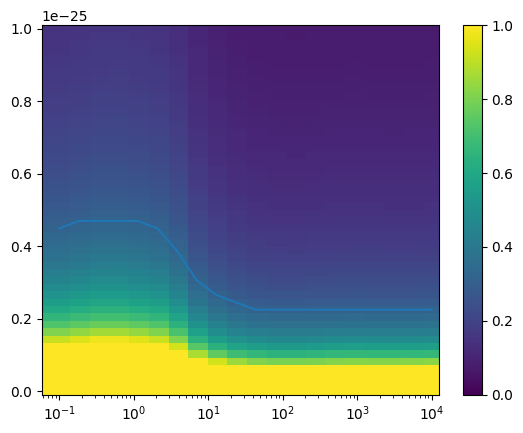

In [185]:
pcm = plt.pcolormesh(m_DM_list, sigma_v_list, sigma_v_res.T, shading='auto', vmin=0, vmax=1)
plt.colorbar(pcm)
plt.xscale('log')

sigma_v_match = []
for i, m in enumerate(m_DM_list):
    sigma_v_match.append(sigma_v_list[np.argmin(np.abs(sigma_v_res[i, :]/2.8 - 0.112))])

plt.plot(m_DM_list, sigma_v_match)

In [85]:
sigma_v_res

array([[1.05770542e+05, 3.21781050e+00, 1.69373344e+00, 1.16409505e+00,
        8.90405101e-01, 7.23259418e-01, 6.11004208e-01, 5.28746948e-01,
        4.67219817e-01, 4.18261432e-01, 3.78902403e-01, 3.47087170e-01,
        3.19722118e-01, 2.96959777e-01, 2.77075882e-01, 2.59327311e-01,
        2.44091013e-01, 2.31036777e-01, 2.18702284e-01, 2.08150283e-01],
       [1.70248748e+05, 3.33538524e+00, 1.75636261e+00, 1.20390725e+00,
        9.19458582e-01, 7.47763647e-01, 6.30228774e-01, 5.46662029e-01,
        4.82058859e-01, 4.31448219e-01, 3.91058483e-01, 3.57716495e-01,
        3.29914732e-01, 3.05944409e-01, 2.85742242e-01, 2.67594915e-01,
        2.51903667e-01, 2.38050406e-01, 2.25538617e-01, 2.14383894e-01],
       [2.76445957e+05, 3.45673384e+00, 1.81508474e+00, 1.24458583e+00,
        9.50959479e-01, 7.72364593e-01, 6.50917250e-01, 5.63193406e-01,
        4.96943547e-01, 4.45556201e-01, 4.03751373e-01, 3.68936911e-01,
        3.39894930e-01, 3.14995777e-01, 2.94425722e-01, 2.7560